<h1>Austin, Houston, or San Antonio? Oh my!</h1>

## Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
    1. [break each city into its neighborhoods](#break)
    2. [gather venue data for each neighborhood](#gather)
    3. [perform k-means clustering on all neighborhoods of all cities](#kmean)
    4. [visualize the created clusters](#visualize)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>
Hi, my name is Amanda.

I was born on a small farm in the middle-of-nowhere, Texas. We had ducks, chickens, a miniature donkey, goats, even a pig at some point. Imagine my cultural shock when I was accepted to MIT for undergrad and had to make the move from my small town in Texas to Cambridge, MA.

Initially, it was challenging adjusting to the lifestyle in Cambridge, but I eventually came to love the area and even spent 9 years out of my young adult life in Cambridge. Recently, however, I have decided to make the move back to Texas to be closer to family and to open up housing opportunities since Cambridge is quite expensive. However,I want to find an area that is still similar to the vibe of Cambridge, just located in Texas.

Enter this project: my goal is to analyze the venue data for 3 major cities in Texas (specifically, Houston, Austin, and San Antonio) in order to compare them to Cambridge, MA. This analysis will help me and others who are in a similar situation to myself decide which city is the most similar to Cambridge, MA.  

## Data <a name="data"></a>
In order to answer our question, we need to develop a method for comparing two cities. While there are many, many, many factors we could include in this analysis, we will limit the scope of this project to comparing the <i>neighborhoods</i> of each city. The steps of our analysis include:
<ol>
    <li>break each city into its neighborhoods</li>
    <li>gather venue data for each neighborhood</li>
    <li>perform k-means clustering on all neighborhoods of all cities</li>
    <li>visualize the created clusters</li>
    <li>use the visualization to determine similarity between the cities (this will be our Results)</li>
    
</ol>

Therefore, the corresponding data we will need is:
* neighborhood information for each city which we'll find mainly using Wikipedia
* venue information (location and type) which we will gather using the Foursquare API
* latitude and longitude data for all the neighborhoods for the cities of Cambridge, Austin, Houston, and San Antonio which we'll gather using a mixture of the <i>geopy</i> package as well as Google's search feature

## Methodology <a name="methodology"></a>
At the end of our analysis, we want to be able to look at a horizontal, bar chart for each of the clusters created through <i>k</i>-means, stacked by city for each bar. For example, we want to create a visual like shown below, but replace the food names with cluster labels and the month names with our city names.
<img src="https://live.staticflickr.com/5229/5659583878_c828dd7d1d_b.jpg">
<i>Source: <a href="https://www.flickr.com/photos/laurenmanning/5659583878">https://www.flickr.com/photos/laurenmanning/5659583878</a></i>


By looking at the composition of each cluster, we can better understand how various parts of our 4 different cities are similar and different from each other which will inform our decision about where to relocate to.



### 1. Break each City into its Neighborhoods<a name="break"></a>
First, we will need to find neighborhood data for each of our four cities, a task that is easier said than done. By the end of this step, we want a dataframe which contains the city name, state, neighborhood name, and the latitude and longitude of the center of the neighborhood. First, we'll create an empty dataframe to hold our data:

In [1]:
import pandas as pd

#define column names 
col = ['City', 'State', 'Neighborhood', 'Latitude', 'Longitude']
#create empty dataframe with our column headings defined above:
df = pd.DataFrame(columns=col)

Now we will fill out our dataframe, city by city, as detailed below:

#### Camridge, MA
The city of Cambridge has clearly defined their neighborhoods and offers this information publically on <a href="https://www.cambridgema.gov/CDD/factsandmaps/mapgalleries/neighborhood">their website</a>. Unfortunately, this information is not in an easily scrape-able form, so we will have to create our own dataframe of the neighborhood locations.

First, we'll create a list of the neighborhoods of Cambridge:

In [2]:
cam_neigh = ['East Cambridge', 'Area 2/MIT', 'Wellington-Harrington', 'The Port', 'Cambridgeport', 'Mid-Cambridge', 'Riverside', 'Agassiz', 'Neighborhood Nine', 'West Cambridge', 'North Cambridge', 'Cambridge Highlands', 'Strawberry Hill']

len(cam_neigh) #checking that captured all 13 neighborhoods

13

We'll now use the <i>geopy</i> library in order to find the latitude and longitude data for the center of each of our neighborhoods:

In [3]:
from geopy.geocoders import Nominatim

In [4]:
lat = []
lon = []

for entry in cam_neigh:
    address = entry+", Cambridge, MA"
    geolocator = Nominatim(user_agent='cam_explorer')
    try:
        location = geolocator.geocode(address)
        lat.append(location.latitude)
        lon.append(location.longitude)
    except: #if geopy can't find the longitude and latitude data, then just put (0,0) as the coordinates
        lat.append(0)
        lon.append(0)

print(lat)
print(lon)

[42.3667639, 0, 0, 17.8943384, 42.359611, 42.088442, 42.3750997, 42.385107, 0, 42.9895219, 42.3959298, 0, 42.3795411]
[-71.0800517, 0, 0, -76.3548303, -71.1067156, -84.211181, -71.1056157, -71.121758, 0, -73.4806696, -71.1300532, 0, -71.1531092]


Notice that our geolocator had some trouble finding the latitude and longitude of Area 2/MIT, Wellington-Harrington, Neighborhood Nine, and Cambridge Highlands neighborhoods. Sometimes the <i>geopy</i> library can be a bit finnicky, so after rerunning this code 10 times with no luck, we're just going to manually input the coordinates for these neighorhoods. Our data here comes from a simple Google search.

In [5]:
lat[1]= 42.3570
lon[1]= -71.0929

lat[2]= 42.3713
lon[2]= -71.0929

lat[8] = 42.3864
lon[8] = -71.1270

lat[11] = 42.3890
lon[11] = -71.1478

print(lat)
print(lon)

[42.3667639, 42.357, 42.3713, 17.8943384, 42.359611, 42.088442, 42.3750997, 42.385107, 42.3864, 42.9895219, 42.3959298, 42.389, 42.3795411]
[-71.0800517, -71.0929, -71.0929, -76.3548303, -71.1067156, -84.211181, -71.1056157, -71.121758, -71.127, -73.4806696, -71.1300532, -71.1478, -71.1531092]


Now we'll put all of our data together into our main dataframe:

In [6]:
cam = []
st = []

for i in range(0, len(cam_neigh)):
    cam.append("Cambridge")
    st.append("Massachusetts")
    
cam_tuples = list(zip(cam, st, cam_neigh, lat, lon))
cam_df = pd.DataFrame(cam_tuples, columns = col)

cam_df.head()

,City,State,Neighborhood,Latitude,Longitude
0,Cambridge,Massachusetts,East Cambridge,42.366764,-71.080052
1,Cambridge,Massachusetts,Area 2/MIT,42.357000,-71.092900
2,Cambridge,Massachusetts,Wellington-Harrington,42.371300,-71.092900
3,Cambridge,Massachusetts,The Port,17.894338,-76.354830
4,Cambridge,Massachusetts,Cambridgeport,42.359611,-71.106716


Lastly, we can visualize our neighborhood data using the <i>folium</i> library to ensure that our neighborhood locations look correct:

In [7]:
!conda install -c conda-forge folium=0.5.0 
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

In [8]:
#get the address for Cambridge, MA
address = 'Cambridge, MA'

geolocator = Nominatim(user_agent='cam_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#create map of Cambridge using lat and lon values for Cambridge
map_cambridge = folium.Map(location = [latitude, longitude], zoom_start=12.5)

#add markers to map
for lat, lon, neigh, city in zip(cam_df['Latitude'], cam_df['Longitude'], cam_df['Neighborhood'], cam_df['City']):
    label ='{}, {}'.format(neigh, city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = 'green',
        fill=True,
        fill_color ='#00FF00',
        fill_opacity =0.7,
        parse_html = False).add_to(map_cambridge)
    
map_cambridge

Looks like <i>geopy</i> got some of our coordinates wrong. Let's fix that:

In [9]:
cam_df.at[3, "Latitude"] = 42.3671
cam_df.at[3, "Longitude"] = -71.0958


cam_df.at[5, "Latitude"] = 42.3736
cam_df.at[5, "Longitude"] = -71.1097

cam_df.at[9, "Latitude"] = 42.3768
cam_df.at[9, "Longitude"] = -71.1373

cam_df.head()

,City,State,Neighborhood,Latitude,Longitude
0,Cambridge,Massachusetts,East Cambridge,42.366764,-71.080052
1,Cambridge,Massachusetts,Area 2/MIT,42.357000,-71.092900
2,Cambridge,Massachusetts,Wellington-Harrington,42.371300,-71.092900
3,Cambridge,Massachusetts,The Port,42.367100,-71.095800
4,Cambridge,Massachusetts,Cambridgeport,42.359611,-71.106716


Let's plot again to make sure our neighborhoods look good:

In [10]:
#create map of Cambridge using lat and lon values for Cambridge
map_cambridge = folium.Map(location = [latitude, longitude], zoom_start=12.5)

#add markers to map
for lat, lon, neigh, city in zip(cam_df['Latitude'], cam_df['Longitude'], cam_df['Neighborhood'], cam_df['City']):
    label ='{}, {}'.format(neigh, city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = 'green',
        fill=True,
        fill_color ='#00FF00',
        fill_opacity =0.7,
        parse_html = False).add_to(map_cambridge)
    
map_cambridge

#### Austin, Texas
Luckily, the city of Austin, Texas also has clearly defined neighborhoods. We'll be scraping the Austin neighborhood data using the <i>beautiful soup</i> package from <a href="https://en.wikipedia.org/wiki/List_of_Austin_neighborhoods#Central_Austin">Wikipedia</a> and then using the <i>geopy</i> library to find the latitude and longitude data again.

First, we'll import the needed packages:

In [11]:
from bs4 import BeautifulSoup
import urllib.request

Now we'll scrape our Wikipedia page and then check to see that we scraped correctly:

In [12]:
url = 'https://en.wikipedia.org/wiki/List_of_Austin_neighborhoods#Central_Austin' #page that we want to scrape data from

wiki_page = urllib.request.urlopen(url) #open the Wikipedia page

soup = BeautifulSoup(wiki_page, "lxml") #parse the HTML

soup.prettify()

'<!DOCTYPE html>\n<html class="client-nojs" dir="ltr" lang="en">\n <head>\n  <meta charset="utf-8"/>\n  <title>\n   List of Austin neighborhoods - Wikipedia\n  </title>\n  <script>\n   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"XrrMKgpAML8AAIuKlqMAAADY","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_Austin_neighborhoods","wgTitle":"List of Austin neighborhoods","wgCurRevisionId":937774304,"wgRevisionId":937774304,"wgArticleId":10396703,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["All stub articles","Neighborhoods in Austin, Texas","Texas geography-related lists","Lists of neighborhoods 

In [13]:
ul_tags = soup.find_all('li') #find all list elements in the HTML

all_items = [] #create an empty list to hold all list elements

for tag in ul_tags:
    all_items.append(tag.text.strip())
    
start_index = all_items.index("Bryker Woods") #this is where our neighborhood names start
end_index = all_items.index("Woodstone Village") #this is where our neighborhood names end

aus_neigh = []

aus_neigh = all_items[start_index:end_index+1]

len(aus_neigh) #should be 94

94

Now that we have our neighborhood names, we can find the latitude and longitude data for each one using the <i>geopy</i> package again:

In [14]:
lat_aus = []
lon_aus = []

for entry in aus_neigh:
    address = entry+", Austin, TX"
    geolocator = Nominatim(user_agent='aus_explorer')
    try:
        location = geolocator.geocode(address)
        lat_aus.append(location.latitude)
        lon_aus.append(location.longitude)
    except: #if geopy can't find the longitude and latitude data, then just put (0,0) as the coordinates
        lat_aus.append(0)
        lon_aus.append(0)

print(lat_aus)
print(lon_aus)

[30.305246, 0, 0, 30.2680536, 30.290562350000002, 30.2958956, 30.3457961, 0, 0, 0, 0, 30.3119891, 30.2848643, 0, 30.296822, 30.2737783, 0, 30.39099295, 30.3133901, 30.3115548, 30.311527050000002, 30.2974652, 0, 30.2680536, 30.3393086, 30.4071425, 30.4290225, 30.2039247, 30.3312641, 30.3458293, 0, 30.2958956, 30.324836349999998, 30.4628448, 0, 30.369852, 30.3178817, 30.364689, 30.3325159, 30.36046725, 30.3620719, 30.3135492, 30.3744533, 30.3944521, 30.3555447, 30.390705, 30.3556933, 30.4008884, 30.2727341, 30.2558955, 30.2103976, 34.5665027, 30.2861378, 30.2586757, 0, 30.2552581, 30.2965242, 0, 30.3031249, 30.2153822, 30.2711286, 0, 30.2694276, 30.2515707, 30.255667, 30.2329257, 30.2355778, 30.2385208, 0, 30.2494427, 30.2444744, 30.2542361, 30.2304618, 30.2249463, 30.231001, 30.1865487, 30.0826699, 30.219541, 30.2025935, 30.1622655, 30.1971128, 30.2134646, 30.2319588, 0, 0, 0, 30.2060236, 30.19527215, 30.30925, 0, 30.1746548, 30.2516993, 30.2232099, 30.2050125]
[-97.7545846, 0, 0, -97.7

Notice again that we have the issue where <i>geopy</i> was unable to find the latitude and longitude coordinates for some of our neighborhoods. So let's go ahead and fix that manually:

In [15]:
missing = {}

for (i, item) in enumerate(lat_aus):
    if item == 0:
        missing.update( {aus_neigh[i] : i} )

missing

{'Clarksville Historic District': 1,
 'Caswell Heights': 2,
 'Hyde Park Historic District': 7,
 "Judge's Hill": 8,
 'Lower Waller Creek': 9,
 'North University': 10,
 'Old Pecan Street': 13,
 'Original West University': 16,
 'Shadow Lawn Historic District': 22,
 'Estates of Brentwood': 30,
 'North Campus': 34,
 'Gracy Woods': 54,
 'Far West': 57,
 'West Line Historic District': 61,
 "South Lamar*Spyglass-Barton's Bluffs": 68,
 'Far South Austin/Slaughter-Manchaca': 83,
 'Kincheonville': 84,
 'The Ridge at Lantana': 85,
 'Sunset Valley (incorporated city)': 89}

In [16]:
lat_aus[1] = 30.2802
lon_aus[1] = -97.7591

#lat_aus[2] = #Google does not return any latitude and longitude data for this neighborhood
#lon_aus[2] = 

lat_aus[7] = 30.305833
lon_aus[7] =  -97.73

lat_aus[8] = 30.2820
lon_aus[8] = -97.7478

#lat_aus[9] = #Google does not return any latitude and longitude data for this neighborhood
#lon_aus[9] = 

lat_aus[10] = 30.2977
lon_aus[10] = -97.7376

#lat_aus[13] = #Google does not return any latitude and longitude data for this neighborhood
#lon_aus[13] = 

#lat_aus[16] =#Google does not return any latitude and longitude data for this neighborhood
#lon_aus[16] = 

lat_aus[22] = 30.2614
lon_aus[22] = -97.7763

lat_aus[30] = 30.4445
lon_aus[30] = -97.8218

lat_aus[34] = 30.3193
lon_aus[34] = -97.7300

lat_aus[54] = 30.3891
lon_aus[54] = -97.6942

lat_aus[57] = 30.2672
lon_aus[57] = -97.7431

lat_aus[61] = 30.263611
lon_aus[61] = -97.776667

lat_aus[68] = 30.2372 #Used South Lamar latitude and longitude data
lon_aus[68] = -97.7838

#lat_aus[83] = #Google does not return any latitude and longitude data for this neighborhood
#lon_aus[83] = 

lat_aus[84] = 30.2035
lon_aus[84] = -97.8350

#lat_aus[85] =  #Google does not return any latitude and longitude data for this neighborhood
#lon_aus[85] = 

lat_aus[89] = 30.2286
lon_aus[89] = -97.8150

new_missing = {}

for (i, item) in enumerate(lat_aus):
    if item == 0:
        new_missing.update( {aus_neigh[i] : i} )

new_missing #should only be 6

{'Caswell Heights': 2,
 'Lower Waller Creek': 9,
 'Old Pecan Street': 13,
 'Original West University': 16,
 'Far South Austin/Slaughter-Manchaca': 83,
 'The Ridge at Lantana': 85}

Unfortunately, there were some neighborhoods that don't have latitude and longitude data readily available, so I will not be including them in my analysis. 

Additionally, I found an error on the Wikipedia website that made it so the two neighborhoods South Lamar and Spyglass-Barton's Bluffs ended up as the same list entry. The latiutde and longitude data we currently have for this "neighborhood" is for South Lamar only, so let's update this list element in <i>aus_neigh</i> to reflect this and add in a new list element for Spyglass-Barton's Bluffs.

In [17]:
aus_neigh[68] = 'South Lamar'

aus_neigh.append("Spyglass-Barton's Bluffs")

lat_aus.append(30.3390)
lon_aus.append(-97.7307)

Now we can finally build our dataframe for Austin, Texas.

In [18]:
aus = []
st_TX = []

for i in range(0, len(aus_neigh)):
    aus.append("Austin")
    st_TX.append("Texas")
    
aus_tuples = list(zip(aus, st_TX, aus_neigh, lat_aus, lon_aus))
aus_df = pd.DataFrame(aus_tuples, columns = col)

aus_df.head()

,City,State,Neighborhood,Latitude,Longitude
0,Austin,Texas,Bryker Woods,30.305246,-97.754585
1,Austin,Texas,Clarksville Historic District,30.280200,-97.759100
2,Austin,Texas,Caswell Heights,0.000000,0.000000
3,Austin,Texas,Downtown Austin,30.268054,-97.744764
4,Austin,Texas,Eastwoods,30.290562,-97.731418


In [19]:
aus_df.drop(aus_df[aus_df['Latitude'] == 0].index, inplace=True) #drop all the neighborhoods with no latitude and longitude data

aus_df.head()

,City,State,Neighborhood,Latitude,Longitude
0,Austin,Texas,Bryker Woods,30.305246,-97.754585
1,Austin,Texas,Clarksville Historic District,30.280200,-97.759100
3,Austin,Texas,Downtown Austin,30.268054,-97.744764
4,Austin,Texas,Eastwoods,30.290562,-97.731418
5,Austin,Texas,Hancock,30.295896,-97.724768


Let's again plot our neighborhood data so we can see how it all looks:

In [20]:
#get the address for Austin, TX
aus_address = 'Austin, TX'

geolocator = Nominatim(user_agent='tx_explorer')
location = geolocator.geocode(aus_address)
latitude = location.latitude
longitude = location.longitude

#create map of Austin
map_austin = folium.Map(location = [latitude, longitude], zoom_start=10)

#add markers to map
for lat, lon, neigh, city in zip(aus_df['Latitude'], aus_df['Longitude'], aus_df['Neighborhood'], aus_df['City']):
    label ='{}, {}'.format(neigh, city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = 'blue',
        fill=True,
        fill_color ='#3186cc',
        fill_opacity =0.7,
        parse_html = False).add_to(map_austin)
    
map_austin

Looking at our map, notice that there are a few neighborhoods that are pretty far from the center of Austin. Checking the neighborhood GPS coordinates using Google, it looks like <i>geopy</i> returned incorrect values, so let's fix that:

Additionally, there is one neighborhood (East End) where <i>geopy</i> returned the incorrect coordinates. I was unable to find the proper coordinates for this neighborhood, so we'll exclude it from our analysis as well.

In [21]:
aus_df.drop(aus_df[aus_df['Neighborhood']=="East End"].index, inplace = True)

ind_nb = aus_neigh.index("North Burnet")
ind_oc = aus_neigh.index("Onion Creek")
ind_oh = aus_neigh.index("Oak Hill")
ind_sh = aus_neigh.index("Shady Hollow")

aus_df.at[ind_nb, "Latitude"] = 30.3911
aus_df.at[ind_nb, "Longitude"] = -97.7218

aus_df.at[ind_oc, "Latitude"] = 30.1403
aus_df.at[ind_oc, "Longitude"] = -97.7811

aus_df.at[ind_oh, "Latitude"] = 30.2340
aus_df.at[ind_oh, "Longitude"] = -97.8648

aus_df.at[ind_sh, "Latitude"] = 30.1649
aus_df.at[ind_sh, "Longitude"] = -97.8622

Let's create a new map to see how our data looks now:

In [22]:
map_austin_updated = folium.Map(location = [latitude, longitude], zoom_start=10)

#add markers to map
for lat, lon, neigh, city in zip(aus_df['Latitude'], aus_df['Longitude'], aus_df['Neighborhood'], aus_df['City']):
    label ='{}, {}'.format(neigh, city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = 'blue',
        fill=True,
        fill_color ='#3186cc',
        fill_opacity =0.7,
        parse_html = False).add_to(map_austin_updated)
    
map_austin_updated

Looks good! Now we move on to Houston, TX.

#### Houston, Texas
Interestingly, the city of Houston, TX is organized by <i>super neighborhoods</i> instead of regular neighborhoods. This is most likely due to the fact that Houston is an extremely large city (one of the largest in the entire United States!). Therefore, to simplify our analysis, we will consider the super neighborhoods of Houston to be the same as the neighborhoods of Houston. 

We'll first scrape the super neighborhood data from the <a href="https://en.wikipedia.org/wiki/List_of_Houston_neighborhoods#Alphabetical_list_of_neighborhoods">List of Houston Neighborhood</a> Wikipedia page:

In [23]:
url_hous = 'https://en.wikipedia.org/wiki/List_of_Houston_neighborhoods#Alphabetical_list_of_neighborhoods' #page that we want to scrape data from

hous_wiki_page = urllib.request.urlopen(url_hous) #open the Wikipedia page

In [24]:
hous_soup = BeautifulSoup(hous_wiki_page, "lxml") #parse the HTML
hous_soup.prettify()

'<!DOCTYPE html>\n<html class="client-nojs" dir="ltr" lang="en">\n <head>\n  <meta charset="utf-8"/>\n  <title>\n   List of Houston neighborhoods - Wikipedia\n  </title>\n  <script>\n   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"XrSKUgpAEKcAAEzWbwMAAABH","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_Houston_neighborhoods","wgTitle":"List of Houston neighborhoods","wgCurRevisionId":947781372,"wgRevisionId":947781372,"wgArticleId":5645575,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Webarchive template wayback links","Articles needing additional references from May 2018","All articles ne

In [25]:
hous_table = hous_soup.find('table', class_='wikitable')
#hous_table #check that we grabbed the correct table, uncomment this to see

In [26]:
hous_neigh = [] #define an empty list to hold our neighborhood data

for row in hous_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==4:
        hous_neigh.append(cells[1].find(text=True)) #we only want the neighborhood name and not the other information

print(len(hous_neigh)) #there should be 88
hous_neigh #take a look at our neighborhoods

88


['Willowbrook',
 'Greater Greenspoint',
 'Carverdale\n',
 'Fairbanks',
 'Greater Inwood',
 'Acres Home',
 'Hidden Valley\n',
 'Westbranch\n',
 'Addicks / Park Ten',
 'Spring Branch',
 'Langwood\n',
 'Central Northwest (formerly Near Northwest)\n',
 'Independence Heights',
 'Lazybrook / Timbergrove',
 'Greater Heights',
 'Memorial',
 'Eldridge / West Oaks\n',
 'Briar Forest\n',
 'Westchase',
 'Mid-West (formerly Woodlake/Briarmeadow)\n',
 'Greater Uptown',
 'Washington Avenue',
 'Afton Oaks',
 'Neartown',
 'Alief',
 'Sharpstown',
 'Gulfton',
 'University Place',
 'Westwood',
 'Braeburn',
 'Meyerland',
 'Braeswood',
 'Medical Center',
 'Astrodome Area',
 'South Main\n',
 'Brays Oaks (formerly Greater Fondren S.W.)\n',
 'Westbury',
 'Willow Meadows / Willowbend\n',
 'Fondren Gardens\n',
 'Central Southwest\n',
 'Fort Bend / Houston\n',
 'IAH Airport',
 'Kingwood',
 'Lake Houston',
 'Northside / Northline\n',
 'Jensen',
 'East Little York / Homestead\n',
 'Trinity / Houston Gardens\n',
 'E

Great! Now we need to do some cleaning of our data. Notice that some of our neighborhoods have "\n" on them, so we'll want to get rid of that. Additionally, we'll want to replace any neighborhood name that says "(formerly NAME)" with just the neighborhood name itself so that <i>geopy</i> can actually find the coordinates for us later on. While there is a package called <i>re</i> that we could use to match regular expressions for this, we'll just replace them manually since there are only 3 neighborhoods that have the "(formerly NAME)" tag.

In [27]:
for i, entry in enumerate(hous_neigh): #get rid of "\n"
    hous_neigh[i] = str(entry).rstrip()

In [28]:
ind_cnw = hous_neigh.index("Central Northwest (formerly Near Northwest)")
ind_mw = hous_neigh.index("Mid-West (formerly Woodlake/Briarmeadow)")
ind_bo = hous_neigh.index("Brays Oaks (formerly Greater Fondren S.W.)")

hous_neigh[ind_cnw] = "Central Northwest"
hous_neigh[ind_mw] = "Mid-West"
hous_neigh[ind_bo] = "Brays Oaks"

hous_neigh #check out our neighborhood data after some cleaning up

['Willowbrook',
 'Greater Greenspoint',
 'Carverdale',
 'Fairbanks',
 'Greater Inwood',
 'Acres Home',
 'Hidden Valley',
 'Westbranch',
 'Addicks / Park Ten',
 'Spring Branch',
 'Langwood',
 'Central Northwest',
 'Independence Heights',
 'Lazybrook / Timbergrove',
 'Greater Heights',
 'Memorial',
 'Eldridge / West Oaks',
 'Briar Forest',
 'Westchase',
 'Mid-West',
 'Greater Uptown',
 'Washington Avenue',
 'Afton Oaks',
 'Neartown',
 'Alief',
 'Sharpstown',
 'Gulfton',
 'University Place',
 'Westwood',
 'Braeburn',
 'Meyerland',
 'Braeswood',
 'Medical Center',
 'Astrodome Area',
 'South Main',
 'Brays Oaks',
 'Westbury',
 'Willow Meadows / Willowbend',
 'Fondren Gardens',
 'Central Southwest',
 'Fort Bend / Houston',
 'IAH Airport',
 'Kingwood',
 'Lake Houston',
 'Northside / Northline',
 'Jensen',
 'East Little York / Homestead',
 'Trinity / Houston Gardens',
 'East Houston',
 'Settegast',
 'Northside Village',
 'Kashmere Gardens',
 'El Dorado / Oates Prairie',
 'Hunterwood',
 'Greate

Let's again use <i>geopy</i> to find the latitude and longitude coordinates of our neighborhoods:

In [29]:
lat_hous = []
lon_hous = []

for entry in hous_neigh:
    address = entry+" Houston TX"
    geolocator = Nominatim(user_agent='hous_explorer')
    try:
        location = geolocator.geocode(address)
        lat_hous.append(location.latitude)
        lon_hous.append(location.longitude)
    except: #if geopy can't find the longitude and latitude data, then just put (0,0) as the coordinates
        lat_hous.append(0)
        lon_hous.append(0)

print(lat_hous)
print(lon_hous)

[29.660253849999997, 29.944719, 29.8486866, 29.8527259, 0, 29.770793, 32.956986, 29.839541, 0, 29.7998786, 29.8262816, 29.919902399999998, 29.8369046, 0, 0, 29.6689495, 0, 29.565098, 30.362545, 0, 0, 29.7696418, 29.73178745, 0, 30.952394, 29.684862199999998, 29.716514, 32.320586750000004, 31.0854721, 29.165727, 29.6798302, 29.67870475, 29.586780949999998, 29.6852302, 29.7739892, 29.7133379, 30.1021576, 0, 0, 31.4274044, 29.6049737, 29.9839236, 30.9200724, 30.0001057, 0, 30.299572, 0, 29.766979, 29.8296699, 29.8416141, 30.3950049, 0, 0, 29.99103695, 0, 29.781616, 29.7640162, 31.7127568, 29.744917899999997, 0, 30.2650024, 29.4534589, -28.7085199, 0, 31.0118635, 29.9463843, 0, 0, 0, 29.5968619, 29.1399671, 29.7089777, 0, 29.687357650000003, 29.68100875, 0, 29.6168799, 0, 29.6394372, 0, 30.3180056, 29.7058964, 29.71184985, 29.7998786, 29.778449, 0, 29.7143823, 31.9372936]
[-95.45609615128879, -95.41607390828516, -95.53945014466453, -95.5243864, 0, -95.328129, -96.471735, -95.55152235109065

Let's again make a dictionary of our missing values:

In [30]:
missing_hous = {}

for (i, item) in enumerate(lat_hous):
    if item == 0:
        missing_hous.update( {hous_neigh[i] : i} )

missing_hous

{'Greater Inwood': 4,
 'Addicks / Park Ten': 8,
 'Lazybrook / Timbergrove': 13,
 'Greater Heights': 14,
 'Eldridge / West Oaks': 16,
 'Mid-West': 19,
 'Greater Uptown': 20,
 'Neartown': 23,
 'Willow Meadows / Willowbend': 37,
 'Fondren Gardens': 38,
 'Northside / Northline': 44,
 'East Little York / Homestead': 46,
 'Kashmere Gardens': 51,
 'El Dorado / Oates Prairie': 52,
 'Greater Fifth Ward': 54,
 'Fourth Ward': 59,
 'Greater Eastwood': 63,
 'Greater Third Ward': 66,
 'Greater OST / South Union': 67,
 'Gulfgate Riverview /': 68,
 'Golfcrest / Bellfort / Reveille': 72,
 'South Acres / Crestmont Park': 75,
 'Greater Hobby Area': 77,
 'South Belt / Ellington': 79,
 'Spring Branch East': 85}

It's tedious, but we'll again find the latitude and longitude coordinates manually and input them into our lists:

In [31]:
lat_hous[4] = 29.8657
lon_hous[4] = -95.4804

lat_hous[8] = 29.8133
lon_hous[8] = -95.6455

lat_hous[11] = 29.8327
lon_hous[11] = -95.4448

lat_hous[13] = 29.8016
lon_hous[13] = -95.4381

lat_hous[16] = 29.7324
lon_hous[16] = -95.6480

lat_hous[19] = 29.7375
lon_hous[19] = -95.5142

lat_hous[20] = 29.7410
lon_hous[20] = -95.4610

lat_hous[23] = 29.7427
lon_hous[23] = -95.3992

lat_hous[37] = 29.6733
lon_hous[37] = -95.4399

lat_hous[38] = 29.6263
lon_hous[38] = -95.5013

lat_hous[44] = 29.8595
lon_hous[44] = -95.3847

lat_hous[46] = 29.8714
lon_hous[46] = -95.3006

lat_hous[51] = 29.8004
lon_hous[51] = -95.3170

lat_hous[52] = 29.8052
lon_hous[52] = -95.2405

lat_hous[54] = 29.7761
lon_hous[54] = -95.3265

lat_hous[59] = 29.7579 
lon_hous[59] = -95.3809

lat_hous[63] = 29.7357
lon_hous[63] = -95.3340

lat_hous[66] = 29.7278
lon_hous[66] = -95.3499

lat_hous[67] = 29.6912
lon_hous[67] = -95.3529

lat_hous[68] = 29.7086
lon_hous[68] = -95.3168
hous_neigh[68] = "Gulfgate Riverview / Pine Valley" #fix the name in our neighborhood data

lat_hous[72] = 29.6852
lon_hous[72] = -95.2963

lat_hous[75] = 29.6276
lon_hous[75] = -95.3556

lat_hous[77] = 29.6254
lon_hous[77] = -95.2854

lat_hous[79] = 29.6015
lon_hous[79] =  -95.2161

lat_hous[85] = 29.8029
lon_hous[85] = -95.4755

In [32]:
updated_missing_hous = {}

for (i, item) in enumerate(lat_hous):
    if item == 0:
        updated_missing_hous.update( {hous_neigh[i] : i} )

updated_missing_hous #check that we captured all data

{'Greater Heights': 14}

Almost done. Now we will put all of our data into a single dataframe for Houston neighborhoods:

In [33]:
hous = []
st_TX = []

for i in range(0, len(hous_neigh)):
    hous.append("Houston")
    st_TX.append("Texas")
    
hous_tuples = list(zip(hous, st_TX, hous_neigh, lat_hous, lon_hous))
hous_df = pd.DataFrame(hous_tuples, columns = col)

hous_df.head()

,City,State,Neighborhood,Latitude,Longitude
0,Houston,Texas,Willowbrook,29.660254,-95.456096
1,Houston,Texas,Greater Greenspoint,29.944719,-95.416074
2,Houston,Texas,Carverdale,29.848687,-95.539450
3,Houston,Texas,Fairbanks,29.852726,-95.524386
4,Houston,Texas,Greater Inwood,29.865700,-95.480400


And let's plot to see how our neighborhoods look:

In [34]:
#get the address for Houston, TX
hous_address = 'Houston, TX'

geolocator = Nominatim(user_agent='tx_explorer')
location = geolocator.geocode(hous_address)
latitude = location.latitude
longitude = location.longitude

#create map of Austin
map_houston = folium.Map(location = [latitude, longitude], zoom_start=5)

#add markers to map
for lat, lon, neigh, city in zip(hous_df['Latitude'], hous_df['Longitude'], hous_df['Neighborhood'], hous_df['City']):
    label ='{}, {}'.format(neigh, city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = 'red',
        fill=True,
        fill_color ='#FF6347',
        fill_opacity =0.7,
        parse_html = False).add_to(map_houston)
    
map_houston

Whoa! Looking at our map we can see that our latitude and longitude data for Houston is very much incorrect as our map shows some Houston neighborhoods spreading out all the way to South Africa! After reading <i>geopy</i> documentation and fiddling around with the part of the code that finds the latitude and longitude data, I decided it was better to go ahead and find all the GPS coordinates manually and upload them from a spreadsheet file.

In [35]:
# The code was removed by Watson Studio for sharing.

,City,State,Neighborhood,Latitude,Longitude
0,Houston,Texas,Willowbrook,29.9559,-95.5460
1,Houston,Texas,Greater Greenspoint,29.9407,-95.4139
2,Houston,Texas,Carverdale,29.8587,-95.5452
3,Houston,Texas,Fairbanks / Northwest Crossing,29.8509,-95.5154
4,Houston,Texas,Greater Inwood,29.8657,-95.4804


In [36]:
#get the address for Houston, TX
hous_address = 'Houston, TX'

geolocator = Nominatim(user_agent='tx_explorer')
location = geolocator.geocode(hous_address)
latitude = location.latitude
longitude = location.longitude

#create map of Austin
map_houston = folium.Map(location = [latitude, longitude], zoom_start=10)

#add markers to map
for lat, lon, neigh, city in zip(hous_df['Latitude'], hous_df['Longitude'], hous_df['Neighborhood'], hous_df['City']):
    label ='{}, {}'.format(neigh, city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = 'red',
        fill=True,
        fill_color ='#FF6347',
        fill_opacity =0.7,
        parse_html = False).add_to(map_houston)
    
map_houston

<i>Much</i> better. We can finally move on to our last city, San Antonio.

#### San Antonio, Texas
Searching through several websites, I was unable to find a definitive list of neighborhoods in San Antonio. Therefore, I based the definition of neighborhood for San Antonio off <a href="https://en.wikipedia.org/wiki/Neighborhoods_and_districts_of_San_Antonio#References">this Wikipedia page</a> and created my own spreadsheet of latitude and longitude data by Googling the various neighborhoods identified in the article. We'll import my spreadsheet and then plot to see our results:

In [37]:
# The code was removed by Watson Studio for sharing.

,City,State,Neighborhood,Latitude,Longitude
0,San Antonio,Texas,Downtown,29.4284,-98.4870
1,San Antonio,Texas,Midtown,29.4529,-98.4918
2,San Antonio,Texas,Southtown,29.4147,-98.4888
3,San Antonio,Texas,Alamo Heights,29.4850,-98.4659
4,San Antonio,Texas,Uptown,29.5614,-98.4215


In [38]:
#get the address for San Antonio, TX
sa_address = 'San Antonio, TX'

geolocator = Nominatim(user_agent='tx_explorer')
location = geolocator.geocode(sa_address)
latitude = location.latitude
longitude = location.longitude

#create map of Austin
map_sa = folium.Map(location = [latitude, longitude], zoom_start=10)

#add markers to map
for lat, lon, neigh, city in zip(sa_df['Latitude'], sa_df['Longitude'], sa_df['Neighborhood'], sa_df['City']):
    label ='{}, {}'.format(neigh, city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = 'purple',
        fill=True,
        fill_color ='#8B008B',
        fill_opacity =0.7,
        parse_html = False).add_to(map_sa)
    
map_sa

Looks good! Now we can put all four of our dataframes together and move on to the next step in our analysis.

In [39]:
all_cities = [cam_df, hous_df, aus_df, sa_df]

df = pd.concat(all_cities, ignore_index=True)

df.head(20)

,City,State,Neighborhood,Latitude,Longitude
0,Cambridge,Massachusetts,East Cambridge,42.366764,-71.080052
1,Cambridge,Massachusetts,Area 2/MIT,42.357000,-71.092900
2,Cambridge,Massachusetts,Wellington-Harrington,42.371300,-71.092900
3,Cambridge,Massachusetts,The Port,42.367100,-71.095800
4,Cambridge,Massachusetts,Cambridgeport,42.359611,-71.106716
5,Cambridge,Massachusetts,Mid-Cambridge,42.373600,-71.109700
6,Cambridge,Massachusetts,Riverside,42.375100,-71.105616
7,Cambridge,Massachusetts,Agassiz,42.385107,-71.121758
8,Cambridge,Massachusetts,Neighborhood Nine,42.386400,-71.127000
9,Cambridge,Massachusetts,West Cambridge,42.376800,-71.137300


### 2. Gather Venue Data for Each Neighborhood<a name="gather"></a>
Next we will collect venue data for each of our neighborhoods to use for <i>k-mean</i> clustering later on in our analysis. We'll be using a FourSquare API in order to accomplish this task. First, we'll define our credentials for accessing the FourSquare API and import the needed packages. Then, we will define a function which will make it easier for us to collect venue data for each neighborhood.

In [40]:
import json 
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np

In [41]:
# The code was removed by Watson Studio for sharing.

In [42]:
def getNearbyVenues(names, city, state, latitudes, longitudes, radius=1600, LIMIT=100):
    
    venues_list=[]
    for name, cit, st, lat, lng in zip(names, city, state, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            st,
            cit,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['State', 'City', 'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Notice from the defintion of our function that we are implementing 2 simplification measures: 
1. We limit the number of venues to 100 to keep our dataframe size manageable
2. We assume each neighborhood has a radius of 1600 meters (about a mile)

The first assumption doesn't bring up too many issues in our analysis since we are using venue data to mainly characterize each neighborhood (i.e. sampling 100 venues from a region is more than enough data to generalize what type of neighborhood we have). 

The second assumption, however, is a little more problematic. Just glancing at the maps of our 4 cities reveals that the distances between each neighborhood varies greatly, with some neighborhoods being less than 1600 meters away from each other and others being way more than 1600 meters away from each other. Consequently, in our treatment of neighborhoods as perfect circles of radius 1600 meters, some of our neighborhoods are going to overlap while other neighborhoods will be missing some venue data altogether. However, we argue that we can still gain some insight into the comparisons between neighborhoods even with this simplifying measure put into place and will continue with our analysis regardless.

Continuing forward:

In [43]:
venues = getNearbyVenues(names=df['Neighborhood'], city=df['City'], state=df['State'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

venues.head()

,State,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Massachusetts,Cambridge,East Cambridge,42.366764,-71.080052,Toscanini’s Ice Cream,42.366016,-71.078189,Ice Cream Shop
1,Massachusetts,Cambridge,East Cambridge,42.366764,-71.080052,Tatte Bakery & Cafe,42.364978,-71.082849,Café
2,Massachusetts,Cambridge,East Cambridge,42.366764,-71.080052,The Similans,42.366448,-71.078047,Thai Restaurant
3,Massachusetts,Cambridge,East Cambridge,42.366764,-71.080052,Intrepid Cafe,42.366189,-71.077996,Café
4,Massachusetts,Cambridge,East Cambridge,42.366764,-71.080052,Helmand Restaurant,42.366529,-71.078079,Afghan Restaurant


In [44]:
print("We collected ", str(venues.shape[0]), " venues!")

We collected  12678  venues!


Let's see how many venues we collected per neighborhood:

In [45]:
venues[['Neighborhood', 'Venue']].groupby("Neighborhood").count()

,Venue
Neighborhood,
Acres Home,5
Addicks / Park Ten,7
Afton Oaks / River Oaks,100
Agassiz,100
Alamo Heights,73
Alief,34
Allandale,100
Area 2/MIT,100
Astrodome Area,100


Notice that some of our nieghborhoods have either 1 venue or no venues. This is most likely due to the fact that these areas are more residential and thus will not have that many venues to boast of. Let's see how many of our neighborhoods have less than 10 venues:

In [46]:
neigh_venue_counts = venues[['Neighborhood', 'Venue']].groupby("Neighborhood").count()

neigh_venue_counts[neigh_venue_counts.Venue < 10]

,Venue
Neighborhood,
Acres Home,5
Addicks / Park Ten,7
Canyon Creek,6
Central Southwest,7
Circle C Ranch,2
Clinton Park / Tri-Community,4
East Houston,6
El Dorado / Oates Prairie,3
Fort Bend / Houston,9


We'll drop these neighborhoods from our analysis since <10 venues doesn't seem like enough data to accurately characterize the neighborhood.

In [47]:
list_to_drop = neigh_venue_counts[neigh_venue_counts.Venue < 10].reset_index().Neighborhood.to_list()

venues = venues[~venues["Neighborhood"].isin(list_to_drop)]

venues.head()

,State,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Massachusetts,Cambridge,East Cambridge,42.366764,-71.080052,Toscanini’s Ice Cream,42.366016,-71.078189,Ice Cream Shop
1,Massachusetts,Cambridge,East Cambridge,42.366764,-71.080052,Tatte Bakery & Cafe,42.364978,-71.082849,Café
2,Massachusetts,Cambridge,East Cambridge,42.366764,-71.080052,The Similans,42.366448,-71.078047,Thai Restaurant
3,Massachusetts,Cambridge,East Cambridge,42.366764,-71.080052,Intrepid Cafe,42.366189,-71.077996,Café
4,Massachusetts,Cambridge,East Cambridge,42.366764,-71.080052,Helmand Restaurant,42.366529,-71.078079,Afghan Restaurant


Now we'll do a onehot encoding of our neighborhoods to perform the <i>k-mean</i> analysis on it later:

In [90]:
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

#add back in neighborhood and city data as one (this helps with making sure two neighborhoods with the same name but from different cities don't get grouped later on)
venues_onehot['Neighborhood-City'] = venues['Neighborhood'].str.cat(venues['City'], sep='@')  

new_cols = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1]) #fix the ordering

venues_onehot = venues_onehot[new_cols]

venues_onehot.head()

,Neighborhood-City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,East Cambridge@Cambridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,East Cambridge@Cambridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,East Cambridge@Cambridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,East Cambridge@Cambridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,East Cambridge@Cambridge,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The last step we'll do in characterizing our neighborhoods is to look at the top 5 types of venues for each neighborhood. We'll first borrow a function from IBM's Data Science course that will sort the types of venues in descending order:

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

And we'll use this function to create a dataframe which displays the top 5 venues for each neighborhood. This will make it easier later on to characterize the clusters that our <i>k-mean</i> clustering creates.

In [103]:
venues_grouped = venues_onehot.groupby('Neighborhood-City').mean().reset_index()

num_top_venues = 5

indicators = ['st', 'nd', 'rd', 'th']

# create columns according to number of top venues
columns = ['Neighborhood-City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighborhood-City'] = venues_grouped['Neighborhood-City']

for ind in np.arange(venues_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head(50)

,Neighborhood-City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Afton Oaks / River Oaks@Houston,Clothing Store,Hotel,Department Store,Cosmetics Shop,Shopping Mall
1,Agassiz@Cambridge,Café,Mexican Restaurant,Bakery,Japanese Restaurant,Pizza Place
2,Alamo Heights@San Antonio,Ice Cream Shop,Bakery,Italian Restaurant,American Restaurant,Vegetarian / Vegan Restaurant
3,Alief@Houston,Fast Food Restaurant,Pizza Place,Video Store,Discount Store,Taco Place
4,Allandale@Austin,Bakery,Food Truck,Pizza Place,Ice Cream Shop,Bar
5,Area 2/MIT@Cambridge,Bakery,American Restaurant,Pizza Place,Coffee Shop,Italian Restaurant
6,Astrodome Area@Houston,Mobile Phone Shop,Mexican Restaurant,Sandwich Place,Donut Shop,Coffee Shop
7,Balcones Woods@Austin,Gym / Fitness Center,Pet Store,Chinese Restaurant,Grocery Store,Park
8,Barrington Oaks@Austin,Asian Restaurant,Video Store,Pizza Place,Park,Sandwich Place
9,Barton Hills@Austin,Taco Place,Art Gallery,Trail,Gym,Bar


### 3. Perform <i>k-means</i> Clustering on All Neighborhoods of All Cities<a name="kmean"></a>
We will now see which neighborhoods from all of our neighborhoods form "clusters" -- i.e. which neighborhoods out of all of our neighborhoods are similar to each other. To do this, we will use an unsupervised ML algorithm called <i>k-means</i> clustering to appropriately cluster our neighborhoods together. We start by importing the needed packages:

In [104]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

For <i>k-means</i> clustering, you must tell the algorithm how many clusters you want to group your data in. We'll determine the best values of <i>k</i> using the <a href="https://www.scikit-yb.org/en/latest/api/cluster/elbow.html">Elbow Method</a>.

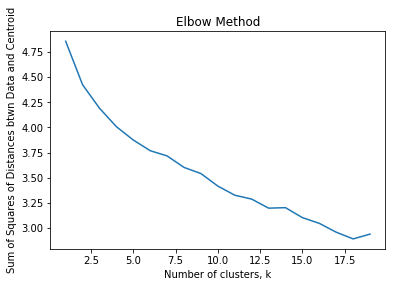

In [105]:
X = venues_grouped.drop('Neighborhood-City', 1) #drop the categorical data

sum_of_squares = []

#fit a k-means model for k values between 1 and 20
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    sum_of_squares.append(kmeans.inertia_)

#plot resulting sum of squares of the distances between each data point in all clusters to their respective centroids
plt.plot(range(1, 20), sum_of_squares)
plt.title('Elbow Method')
plt.xlabel('Number of clusters, k')
plt.ylabel('Sum of Squares of Distances btwn Data and Centroid')
plt.show()

From our plot, we can see that our best value for <i>k</i> is <i>k=13</i> (This is for data that was collected on May 13, 2020.)

In [106]:
k = 13
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(X)

Now that we have our <i>k</i>-value label, we can add this back to our dataframe:

In [107]:
venues_sorted["Cluster Label"] = kmeans.labels_

venues_sorted.head()

,Neighborhood-City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Label
0,Afton Oaks / River Oaks@Houston,Clothing Store,Hotel,Department Store,Cosmetics Shop,Shopping Mall,0
1,Agassiz@Cambridge,Café,Mexican Restaurant,Bakery,Japanese Restaurant,Pizza Place,12
2,Alamo Heights@San Antonio,Ice Cream Shop,Bakery,Italian Restaurant,American Restaurant,Vegetarian / Vegan Restaurant,12
3,Alief@Houston,Fast Food Restaurant,Pizza Place,Video Store,Discount Store,Taco Place,1
4,Allandale@Austin,Bakery,Food Truck,Pizza Place,Ice Cream Shop,Bar,0


### 4. Visualize the Created Clusters<a name="visualize"></a>

We will now plot our cluster data on horizontal bar charts to see the composition of each cluster by city. To do this, we first need to import some packages and then separate the column called "Neighborhood-City" into "Neighborhood" and "City". Then, we will plot.

In [108]:
import matplotlib.patches as mpatches

In [109]:
split_df = venues_sorted["Neighborhood-City"].str.split("@", n=1, expand = True)

venues_sorted["City"] = split_df[1]

venues_sorted["Neighborhood"] = split_df[0]

venues_sorted.drop(columns =["Neighborhood-City"], inplace = True)

venues_sorted.tail(50)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Label,City,Neighborhood
129,Doctor's Office,Dry Cleaner,Video Store,Gift Shop,Mobile Phone Shop,3,Austin,Sendera
130,Coffee Shop,Trail,Mexican Restaurant,Gym / Fitness Center,Park,9,Austin,Shadow Lawn Historic District
131,Furniture / Home Store,Fast Food Restaurant,Sandwich Place,Pizza Place,Thrift / Vintage Store,1,Houston,Sharpstown
132,Sandwich Place,Coffee Shop,Ice Cream Shop,Mexican Restaurant,Food Truck,9,Austin,Shoal Crest
133,Food,BBQ Joint,Grocery Store,Cocktail Bar,Discount Store,6,Houston,South Acres / Crestmont Park
134,Vietnamese Restaurant,Sports Bar,Fast Food Restaurant,Cajun / Creole Restaurant,Donut Shop,0,Houston,South Belt / Ellington
135,Hotel,Coffee Shop,Mexican Restaurant,Taco Place,Park,5,Austin,South Congress
136,Mexican Restaurant,Taco Place,Coffee Shop,Discount Store,Liquor Store,0,Austin,South Lamar
137,Mexican Restaurant,Fast Food Restaurant,BBQ Joint,Fried Chicken Joint,Sports Bar,1,Houston,South Main
138,Mexican Restaurant,Taco Place,Food Truck,Discount Store,Pizza Place,0,Austin,South Manchaca


Now we'll group our data into cluster labels and cities (i.e. we want to see how many instances of Cambridge are in Cluster 0, Cluster 1, etc.). We'll use a groupby in order to do this:

In [117]:
city_clust_df = venues_sorted.groupby(['Cluster Label', 'City']).size()

city_clust_df

Cluster Label  City       
0              Austin         23
               Houston        15
               San Antonio     2
1              Austin          4
               Houston        28
               San Antonio     1
2              Houston         1
               San Antonio     2
3              Austin         14
               Cambridge       1
               Houston         5
               San Antonio     2
4              Austin          5
               Houston         4
5              Austin          7
               Houston         5
               San Antonio     1
6              Houston         1
7              Houston         1
8              San Antonio     1
9              Austin         28
               Houston         8
               San Antonio     1
10             Austin          1
               San Antonio     1
11             Houston         3
12             Cambridge      12
               Houston         1
               San Antonio     1
dtype: int64

We'll now convert this pandas Series into a list so that we can plot it:

In [118]:
aus_list = []
cam_list = []
hous_list = []
sa_list = []

for i in range(0,13):
    try:
        aus_list.append(city_clust_df[i]["Austin"])
    except:
        aus_list.append(0)
        
for i in range(0,13):
    try:
        cam_list.append(city_clust_df[i]["Cambridge"])
    except:
        cam_list.append(0)
        
for i in range(0,13):
    try:
        hous_list.append(city_clust_df[i]["Houston"])
    except:
        hous_list.append(0)
        
for i in range(0,13):
    try:
        sa_list.append(city_clust_df[i]["San Antonio"])
    except:
        sa_list.append(0)

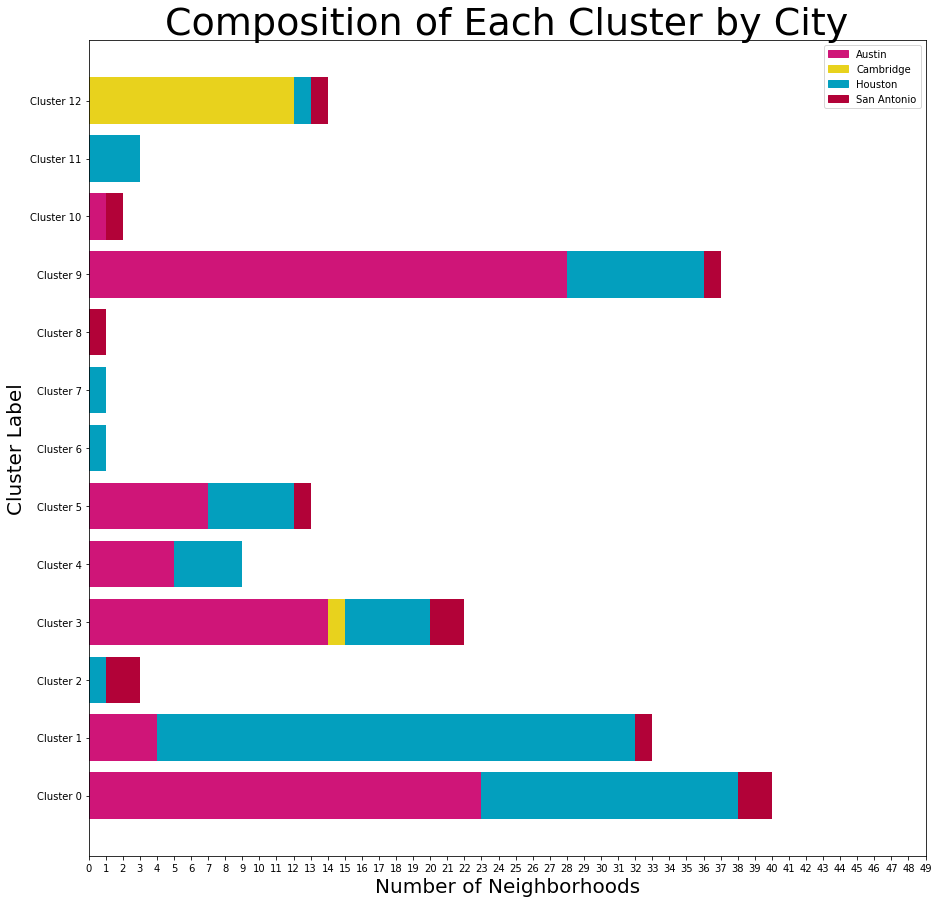

In [126]:
y = np.arange(len(aus_list))
plt.figure(figsize=(15,15))


#plot each bar piece
plt.barh(y, aus_list, color = '#cf1578')
plt.barh(y, cam_list, color = '#e8d21d', left=aus_list)
plt.barh(y, hous_list, color = '#039fbe', left=list(map(lambda g, y: g + y, aus_list, cam_list)))
plt.barh(y, sa_list, color = '#b20238', left=list(map(lambda g, y, b: g + y + b, aus_list, cam_list, hous_list)))

#labels for graph
plt.xticks(np.arange(0,50,1))
y_labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8", "Cluster 9", "Cluster 10", "Cluster 11", "Cluster 12"]
plt.yticks(y, y_labels)
plt.title("Composition of Each Cluster by City", fontdict = {'fontsize' : 38})
plt.xlabel("Number of Neighborhoods", fontdict = {'fontsize' : 20})
plt.ylabel("Cluster Label", fontdict = {'fontsize' : 20})

#legend
aus_patch =mpatches.Patch(color="#cf1578", label = "Austin")
cam_patch =mpatches.Patch(color="#e8d21d", label = "Cambridge")
hous_patch =mpatches.Patch(color="#039fbe", label = "Houston")
sa_patch =mpatches.Patch(color="#b20238", label = "San Antonio")
plt.legend(handles=[aus_patch, cam_patch, hous_patch, sa_patch], loc="upper right")



Woohoo! We have <i>finally</i> produced the graphic that we set out to create. However, one issues that you might have noticed looking at our graph is that it seems to be dominated by Austin and Houston. This is because the number of neighborhoods in these two cities is significantly bigger than the number of neighborhoods in San Antonio and Cambridge. Therefore, to make a more fair comparison of the composition of our clusters, we'll normalize the data we have and then plot again.

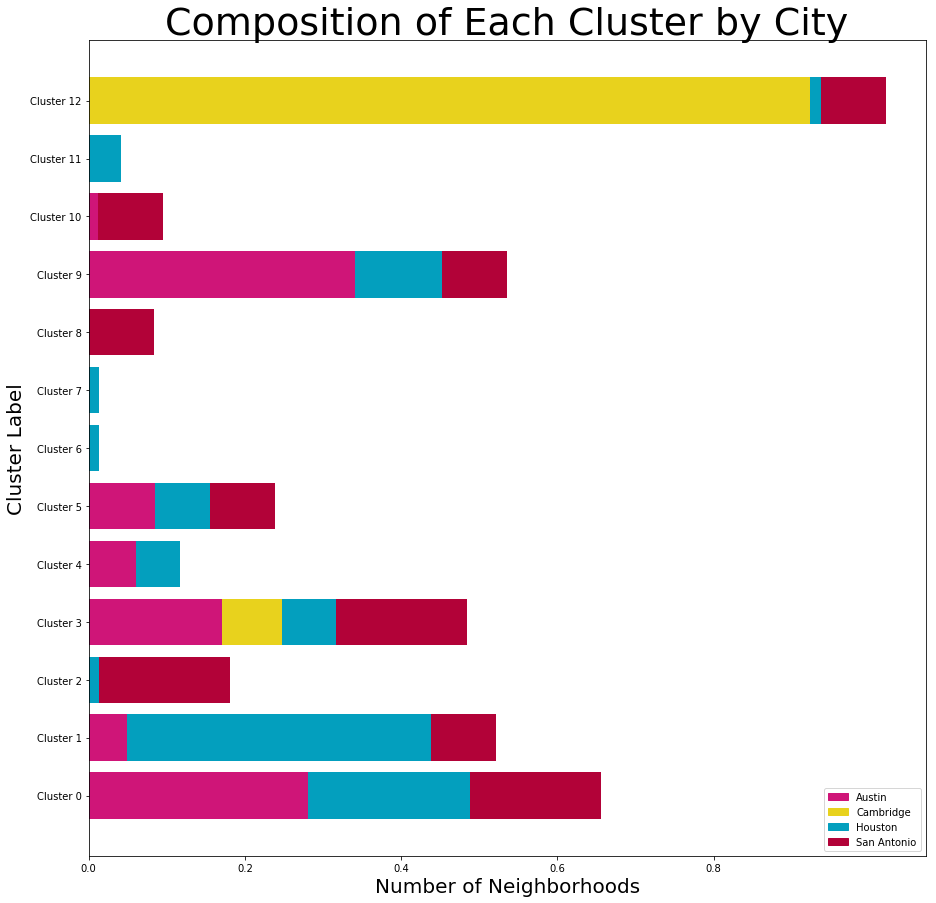

In [128]:
aus_n = [a/sum(aus_list) for a in aus_list]
cam_n = [c/sum(cam_list) for c in cam_list]
hous_n = [h/sum(hous_list) for h in hous_list]
sa_n = [s/sum(sa_list) for s in sa_list]

y = np.arange(len(aus_n))
plt.figure(figsize=(15,15))


#plot each bar piece
plt.barh(y, aus_n, color = '#cf1578')
plt.barh(y, cam_n, color = '#e8d21d', left=aus_n)
plt.barh(y, hous_n, color = '#039fbe', left=list(map(lambda g, y: g + y, aus_n, cam_n)))
plt.barh(y, sa_n, color = '#b20238', left=list(map(lambda g, y, b: g + y + b, aus_n, cam_n, hous_n)))

#labels for graph
plt.xticks(np.arange(0,1,0.2))
y_labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8", "Cluster 9", "Cluster 10", "Cluster 11", "Cluster 12"]
plt.yticks(y, y_labels)
plt.title("Composition of Each Cluster by City", fontdict = {'fontsize' : 38})
plt.xlabel("Number of Neighborhoods", fontdict = {'fontsize' : 20})
plt.ylabel("Cluster Label", fontdict = {'fontsize' : 20})

#legend
aus_patch =mpatches.Patch(color="#cf1578", label = "Austin")
cam_patch =mpatches.Patch(color="#e8d21d", label = "Cambridge")
hous_patch =mpatches.Patch(color="#039fbe", label = "Houston")
sa_patch =mpatches.Patch(color="#b20238", label = "San Antonio")
plt.legend(handles=[aus_patch, cam_patch, hous_patch, sa_patch], loc="lower right")

## Results <a name="results"></a>
Alrighty, so let's now look at the graph we created above. What we have created is a horizontal, stacked bar chart of the various clusters we created using <i>k</i>-mean clustering. Each horizontal bar is comprised of neighborhoods from either Austin, Cambridge, Houston, or San Antonio that share similar features (as determined by our ML algorithm).

Notice that Cambridge only appears in 2 clusters (Cluster 3 and Cluster 12) and, in fact, dominates cluster 12. This would seem to imply that neighborhoods in Cambridge are, for the most part, similar to each other but not similar to neighborhoods in any of our three cities. There is some evidence in our chart that suggests this may also hold true for Austin, Houston, and San Antonio (but to a lesser degree). For example, cluster 6, 7, and 11 are entirely made up of Houston neighborhoods while clusters 2, 8, and 10 are dominated by San Antonio. This would imply that these neighborhoods from these cities are similar to each other, but not so similar to neighborhoods in other cities.

Interestingly, Austin decisively dominates only one cluster (Cluster 9) compared to three clusters for San Antonio and 4 clusters for Houston. Consequently, so one might think that Austin makes an appearance in more clusters than Houston or San Antonio (the neighborhoods of Austin should be more spread out since they only gorup around one cluster). However, this is not the case, and Austin actually occurs with less frequency among the clusters than both San Antonio and Houston. 

## Discussion <a name="discussion"></a>
So what does this mean in terms of choosing Austin, San Antonio, or Houston? It seems like our efforts to pick a city that is similar to Cambridge, MA out of the three listed is not a fruitful endeavor (at least, trying to decide based off neighborhoods and their venues doesn't seem to be helpful). 

However, our efforts aren't completely wasted. Notice that clusters 12 and 3 include neighborhoods for Austin, San Antonio, and Houston. So while we may not be able to pick a city that is similar to Cambridge, what we <i>can</i> do is find the neighborhoods in Austin, San Antonio, and Houston that are similar to parts of Cambridge. These would be:

In [138]:
clus_3 = venues_sorted[venues_sorted["Cluster Label"] == 3][["Neighborhood", "City"]]

clus_3[clus_3["City"] != "Cambridge"]

,Neighborhood,City
7,Balcones Woods,Austin
8,Barrington Oaks,Austin
13,Braeswood,Houston
21,Central Northwest,Houston
22,Cherry Creek,Austin
23,Clarksville Historic District,Austin
24,Clear Lake,Houston
38,East Side,San Antonio
42,Estates of Brentwood,Austin
76,Kincheonville,Austin


In [139]:
clus_12 = venues_sorted[venues_sorted["Cluster Label"] == 12][["Neighborhood", "City"]]

clus_12[clus_12["City"] != "Cambridge"]

,Neighborhood,City
2,Alamo Heights,San Antonio
57,Greater Heights,Houston


## Conclusion <a name="conclusion"></a>

In our report, we showed how we could potentially use neighborhood venue data in order to compare different cities. Future work on this project could include more clearly defining the boundaries of our neighborhoods (vs. utilizing circles) in order to improve the accuracy of our analysis. Additionally, we could also increase the limit on the number of venues we pull into our database using the FourSquare API. 

I greatly enjoyed working on this project, and I can't wait to explore the neighborhoods of Houston, Austin, and San Antonio that are similar to some of the neighborhoods in Cambridge.

Happy city exploring!